# Computer Vision Algorithms

## Haar Cascade Classifier

It includes multiple stages: feature extraction, feature selection, and training a classifier.

### 1. **Haar-like Features**

Haar-like features are rectangular patterns that detect specific visual characteristics. A common set of Haar features for `face detection` includes:

- **Edge features**: Detects boundaries, such as between the forehead and eyes.
- **Line features**: Detects horizontal or vertical changes, useful for spotting features like the bridge of the nose.
- **Four-rectangle features**: Used for detecting contrast, like between eyes and eyebrows.

Each feature calculates the difference in pixel intensity between black and white regions. This is done by summing the pixel values of the regions and subtracting the sums.

### 2. **Integral Image**

An integral image helps to compute the sum of pixel intensities within a rectangular region very quickly. It’s a 2D matrix where each element represents the sum of all pixels above and to the left of it.

- To create an integral image, use the formula:
$$
\text{IntegralImage}(x, y) = \text{Image}(x, y) + \text{IntegralImage}(x-1, y) + \text{IntegralImage}(x, y-1) - \text{IntegralImage}(x-1, y-1)
$$
- Using this integral image, we can compute the sum of any rectangular area in constant time.

### 3. **Feature Selection Using AdaBoost**

**AdaBoost** assigns higher weights to incorrectly classified samples to "boost" weak classifiers into a strong classifier. The algorithm combines many weak classifiers (simple threshold-based on a single Haar-like feature) to build a cascade of classifiers that improves detection accuracy.

### 4. **Training the Cascade Classifier**

The cascade structure consists of multiple stages. Each stage is a separate classifier that filters out negative samples (non-faces) quickly, passing only promising regions to the next stage.

In [ ]:
import numpy as np
import cv2

# Step 1: Compute the Integral Image
def integral_image(img):
    # Sum over rows and columns to get the integral image
    return img.cumsum(axis=0).cumsum(axis=1)

# Step 2: Define Haar-like features
class HaarFeature:
    def __init__(self, feature_type, position, width, height):
        self.feature_type = feature_type  # Types: 'two-rect', 'three-rect', 'four-rect'
        self.position = position          # (x, y) position
        self.width = width
        self.height = height

    def compute(self, int_img):
        x, y = self.position
        w, h = self.width, self.height

        if self.feature_type == 'two-rect':
            # Example of horizontal two-rect feature
            white = int_img[y:y+h, x:x+w//2].sum()
            black = int_img[y:y+h, x+w//2:x+w].sum()
            return white - black
        # Add more feature types as needed
        return 0

# Step 3: Create a Classifier based on Haar features
class WeakClassifier:
    def __init__(self, feature, threshold, polarity):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

    def predict(self, int_img):
        feature_value = self.feature.compute(int_img)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold else 0

# Step 4: Train a simple weak classifier (simplified without AdaBoost)
def train_classifier(pos_imgs, neg_imgs, feature):
    best_classifier = None
    best_accuracy = 0
    for threshold in np.linspace(-1, 1, num=10):  # Test different thresholds
        for polarity in [1, -1]:
            correct = 0
            classifier = WeakClassifier(feature, threshold, polarity)
            for img in pos_imgs:
                if classifier.predict(integral_image(img)) == 1:
                    correct += 1
            for img in neg_imgs:
                if classifier.predict(integral_image(img)) == 0:
                    correct += 1
            accuracy = correct / (len(pos_imgs) + len(neg_imgs))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_classifier = classifier
    return best_classifier

# Step 4: full ver
def adaboost_train(features, pos_integral_images, neg_integral_images):
    # Initialize weights for positive and negative samples
    num_pos, num_neg = len(pos_integral_images), len(neg_integral_images)
    weights = np.hstack((np.ones(num_pos) / (2 * num_pos), np.ones(num_neg) / (2 * num_neg)))
    classifiers = []

    for feature in features:
        best_classifier = None
        best_accuracy = 0
        
        for threshold in np.linspace(-1, 1, num=10):
            for polarity in [1, -1]:
                # Initialize a weak classifier with a feature
                classifier = WeakClassifier(feature, threshold, polarity)
                predictions = []

                # Calculate accuracy on positive and negative samples
                for img in pos_integral_images:
                    predictions.append(classifier.predict(img))
                for img in neg_integral_images:
                    predictions.append(1 - classifier.predict(img))
                
                accuracy = sum(predictions) / (num_pos + num_neg)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_classifier = classifier
        
        classifiers.append(best_classifier)
        # Update weights for misclassified samples (simplified)
        # Update weights in AdaBoost to focus on misclassified samples
    return classifiers

# Step 5: Apply a cascade of classifiers to detect faces
def detect_faces(img, classifiers):
    int_img = integral_image(img)
    for classifier in classifiers:
        if classifier.predict(int_img) == 0:
            return False  # Non-face region
    return True  # Face detected

# Step 5: full ver
class CascadeStage:
    def __init__(self, classifiers, threshold):
        self.classifiers = classifiers
        self.threshold = threshold

    def classify(self, integral_image):
        stage_sum = sum(clf.predict(integral_image) for clf in self.classifiers)
        return stage_sum >= self.threshold  # Pass if stage sum is above threshold
    
class HaarCascade:
    def __init__(self, stages):
        self.stages = stages

    def detect(self, image):
        integral_img = integral_image(image)
        for stage in self.stages:
            if not stage.classify(integral_img):
                return False  # Non-face region
        return True  # Face detected
    
# Step 6: (only for full ver) apply the trained cascade on different regions (windows) of an image to detect faces.
def sliding_window(image, cascade, window_size=(24, 24), step_size=4):
    detected_regions = []
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if cascade.detect(window):
                detected_regions.append((x, y, window_size[0], window_size[1]))
    return detected_regions

# Example Usage
if __name__ == "__main__":
    # Load example images (replace with actual images)
    pos_imgs = [cv2.imread("face1.jpg", cv2.IMREAD_GRAYSCALE)]  # Positive samples
    neg_imgs = [cv2.imread("non_face1.jpg", cv2.IMREAD_GRAYSCALE)]  # Negative samples

    # Define a Haar feature and train a classifier
    feature = HaarFeature("two-rect", (0, 0), 24, 24)
    classifier = train_classifier(pos_imgs, neg_imgs, feature)

    # Cascade of classifiers (for simplicity, using only one trained classifier)
    cascade = [classifier]

    # Detect face in a test image
    test_img = cv2.imread("test.jpg", cv2.IMREAD_GRAYSCALE)
    if detect_faces(test_img, cascade):
        print("Face detected!")
    else:
        print("No face detected.")

### Explanation of Key Components

1. **Integral Image Calculation**: This provides rapid access to rectangular regions, speeding up feature computation.
2. **Haar Feature Calculation**: In this example, we compute a two-rectangle feature by summing two areas and taking the difference.
3. **Weak Classifier Training**: Here, a single weak classifier is trained with various thresholds and polarities. Normally, multiple features and AdaBoost are used to create a strong classifier.
4. **Cascade of Classifiers**: For simplicity, we use one classifier here, but in a full Haar Cascade, several stages are used for efficient face detection.

### Limitations and Enhancements

- **AdaBoost**: A simplified version is shown, but a real implementation would iteratively adjust sample weights and use multiple features per classifier.
- **Training Time**: A real Haar Cascade requires thousands of positive and negative samples and extensive computational resources.

## Laplacian

The **Laplacian** is a mathematical operator widely used in image processing, computer vision, and other fields. It provides a measure of the second derivative of an image, effectively capturing regions of rapid intensity change. These changes often correspond to **edges**, corners, or other significant features in an image.

---

### 1. **Definition**:

The Laplacian is a second-order derivative operator defined as the divergence of the gradient of a function $f(x, y)$. For a 2D scalar function (such as a grayscale image), it is given by:

$$
\Delta f(x, y) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}
$$

Here:
- $\frac{\partial^2 f}{\partial x^2}$: The second derivative in the $x$-direction.
- $\frac{\partial^2 f}{\partial y^2}$: The second derivative in the $y$-direction.

The Laplacian combines these derivatives to capture variations in all directions.

---

### 2. **Laplacian in Image Processing**:

In images, the Laplacian is used to highlight areas of intensity change (e.g., edges). It emphasizes regions where the intensity transitions rapidly, such as edges or textures.
#### Discrete Approximation:
In digital images, the Laplacian is approximated using discrete convolution kernels. Common 3x3 kernels for the Laplacian are:

$$
\begin{bmatrix}
0 & -1 & 0 \\
-1 & 4 & -1 \\
0 & -1 & 0
\end{bmatrix}
\quad \text{or} \quad
\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{bmatrix}
$$

When convolved with an image, these kernels calculate the Laplacian.

---

### 3. **Applications**:

The Laplacian operator is particularly useful for:
- **Edge detection**: Highlights edges where the intensity gradient changes abruptly.
- **Blob detection**: Combined with scale-space analysis (e.g., Laplacian of Gaussian, LoG), it can detect blobs of varying sizes.
- **Sharpening**: Enhances fine details by emphasizing areas of intensity change.
- **Image segmentation**: Helps identify boundaries between different regions.

---

### 4. **Limitations**:

- The Laplacian is sensitive to noise, as noise often causes rapid intensity changes.
- To reduce sensitivity to noise, the Laplacian is often combined with smoothing techniques, such as Gaussian filtering, resulting in the **Laplacian of Gaussian (LoG)** operator.

---

### 5. **Laplacian vs Gradient**:

- **Gradient** (e.g., Sobel operator): Captures the **direction** and **magnitude** of the intensity change (first derivative).
- **Laplacian**: Captures the **rate of change** of the gradient (second derivative), highlighting areas of rapid intensity change regardless of direction.

---

### Demonstration

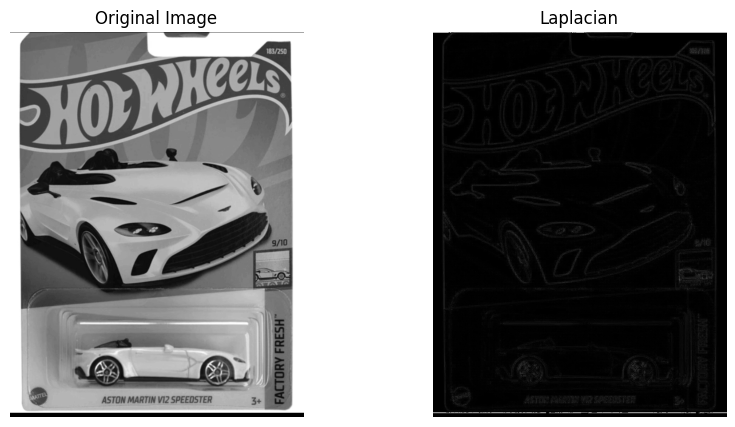

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load an example image in grayscale
image = cv2.imread('./example_data/box_toy.jpg', cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Image not found. Make sure 'example.jpg' is in the working directory.")
else:
    # Apply the Laplacian operator
    laplacian = cv2.Laplacian(image, cv2.CV_64F)  # Use 64-bit float to capture negative values
    laplacian = np.uint8(np.absolute(laplacian))  # Convert back to 8-bit for display

    # Display the original and Laplacian-processed images
    plt.figure(figsize=(10, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Laplacian image - A map highlighting areas of rapid intensity change (edges or boundaries).
    plt.subplot(1, 2, 2)
    plt.imshow(laplacian, cmap='gray')
    plt.title('Laplacian')
    plt.axis('off')
    
    plt.show()

## Scale-Invariant Feature Transform (SIFT)

The **SIFT** algorithm is a computer vision technique used to detect and describe local features in images. It is one of the most popular methods for image processing tasks like object recognition, image matching, and 3D reconstruction.

---

### Key Characteristics of SIFT:

1. **Scale Invariance**: Features detected by SIFT are invariant to changes in scale, meaning it works well for objects at different sizes.
2. **Rotation Invariance**: The algorithm can detect features regardless of the image’s rotation.
3. **Robustness**: It is resilient to changes in illumination, noise, and minor distortions.
4. **Keypoints**: Distinctive image features (corners, blobs, edges).

---

### How SIFT Works:

The algorithm involves 4 main steps:

#### 1. **Scale-Space Extrema Detection**
   - Identifies potential keypoints in an image across different scales.
   - A **scale space** is created by progressively smoothing the image with a Gaussian kernel. The **Difference of Gaussians (DoG)** is computed as:
     $$
     D(x, y, \sigma) = L(x, y, k\sigma) - L(x, y, \sigma)
     $$
     where $L$ is the Gaussian-blurred image at scales $\sigma$ and $k\sigma$.
   - Keypoints are identified as local maxima and minima in the DoG scale space.

#### 2. **Keypoint Localization**
   - Refines the detected keypoints to improve accuracy.
   - Eliminates keypoints that are poorly localized or sensitive to noise.
   - Uses a Taylor series expansion around each keypoint to precisely localize it in the scale-space.

#### 3. **Orientation Assignment**
   - Each keypoint is assigned an orientation based on the gradient directions of the image around the keypoint.
   - This step makes SIFT rotation-invariant.
   - Gradients are calculated as:
     $$
     m(x, y) = \sqrt{(I(x+1, y) - I(x-1, y))^2 + (I(x, y+1) - I(x, y-1))^2}
     $$
     $$
     \theta(x, y) = \tan^{-1}\left(\frac{I(x, y+1) - I(x, y-1)}{I(x+1, y) - I(x-1, y)}\right)
     $$

#### 4. **Keypoint Descriptor Creation**
   - Around each keypoint, a 16×16 window of image gradients is considered, divided into 4×4 subregions.
   - A histogram of gradients is computed for each subregion, resulting in a **128-dimensional feature vector**.
   - This vector is normalized to ensure invariance to changes in illumination.

---

### Applications of SIFT:

1. **Image Matching and Object Recognition**
   - Match keypoints between two images to identify objects or align images.
2. **3D Scene Reconstruction**
   - Use SIFT features from multiple views of a scene to reconstruct its 3D geometry.
3. **Motion Tracking**
   - Track objects in videos using the features detected by SIFT.
4. **Panorama Stitching**
   - Align and stitch images to create panoramas using SIFT keypoints.

---

### Advantages of SIFT:

- **Scale and Rotation Invariant**: Performs well across different zoom levels and rotations.
- **Robust**: Works well even with partial occlusion, illumination changes, and cluttered backgrounds.
- **Descriptive**: Captures rich information about the local region around a keypoint.

---

### Limitations of SIFT:

1. **Computationally Expensive**: Detecting and describing features can be slow for large images or real-time applications.
2. **Not Fully Invariant to Affine Transformations**: While robust, it may not handle extreme perspective distortions.

---

### Example with OpenCV:

In [4]:
import cv2

# Load the image
image = cv2.imread("./example_data/box_toy.jpg", cv2.IMREAD_GRAYSCALE)

# Create a SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display the image
cv2.imshow("SIFT Keypoints", cv2.resize(image_with_keypoints, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA))
cv2.waitKey(0)
cv2.destroyAllWindows()